#  Apprentissage de représentation et triplet loss

Vincent Guigue

Enoncé dérivé de celui de Nicolas Baskiotis (nicolas.baskiotis@sorbonne-universite.fr) -- MLIA/ISIR, Sorbonne Université

Importation des modules nécessaires et configuration de torch/tensorboard

In [ ]:
import csv
import numpy as np
from collections import Counter
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from random import shuffle
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard import notebook

In [ ]:

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
%load_ext tensorboard
%tensorboard --logdir runs

writer = SummaryWriter()

# Jeu de données de recommandation
Ce jeu de données est issu d'un célèbre site sur les jeux de société. Il contient les fichiers suivants :


*   `users.csv `: liste des utilisateurs et de leur identifiant sous la forme `(nickname, id)`
*   `jeux.csv` : liste des jeux et de leur identifiant sous la forme `(id, titre, titre complet, résumé, catégories, âge)`
* `avis.csv` : liste des avis sous la forme `(id,id_jeu,id_user,titre, nickname, date, note, titre commentaire, commentaire)`

Dans cette première partie, nous allons nous intéresser uniquement aux notes données aux jeux par les utilisateurs, sans regarder le contenu. L'objectif est de prédire la note qu'un utilisateur donne à un jeu. Ce problème peut être vu comme de la régression sur la note ou comme un problème de classification multi-classes en discrétisant la note.





On installe tout d'abord les données sur le colab.

In [ ]:
# pour Colab (cf ci-dessous pour travailler en local)

# ## Télécharger le fichier donnees_jds.zip dans votre google drive
# from google.colab import drive
# drive.mount('/content/drive/',force_remount=True)
# ## Changer le PATH vers le fichier de données
# PATH = "/content/drive/MyDrive/data/data_jds/"
# # On décompresse le fichier, les fichiers seront au niveau de /content
# !unzip $PATH"donnees_jds.zip"

In [ ]:
# local
PATH = "data/donnees_jds/"

Nous allons dans un premier temps filtrer les données pour ne garder que des utilisateurs et des jeux ayant suffisament de notes.

**Note:** on se rend vite compte que ce filtrage n'est pas si évident (le nb de revues par objet dépend des auteurs et vice et versa). On procède de manière itérative, jusqu'à convergence.

In [ ]:

def filtre(data,ths_g,ths_u):
    """ filtre les données pour ne garder que des jeux ayant plus de ths_g notes et des users avec plus de ths_u avis """
    lu, lg, ld = 0, 0, len(data)
    old_lu, old_lg = 1,1
    i = 0
    while lu != old_lu or lg != old_lg:
        rawg = Counter([x[1] for x in data])
        rawu = Counter([x[2] for x in data])
        old_lu = lu
        old_lg = lg
        ld = len(data)
        lg = len(rawg)
        lu = len(rawu)
        print(f"Boucle {i} : Nb games : {lg}, Nb Users : {lu}, sparsity : {ld/(lg*lu)}")
        filtre_g = [k for k,v in rawg.items() if v>ths_g]
        filtre_u = [k for k,v in rawu.items() if v>ths_u]
        data = [x for x in data if x[1] in filtre_g and x[2] in filtre_u]
        i = i +1
    return data


In [ ]:
#Lecture des données (google colab)
# dataraw = [x for x in csv.reader(open("./avis.csv"))]
# dic_jeux = dict([(int(x[0]),x[2]) for x in csv.reader(open("./jeux.csv"))])
dataraw = [x for x in csv.reader(open(PATH+"avis.csv"))]
dic_jeux = dict([(int(x[0]),x[2]) for x in csv.reader(open(PATH+"jeux.csv"))])
# Filtrage des données
data_dense = [(int(x[1]),int(x[2]),float(x[6])) for x in filtre(dataraw,30,30)] # on peut jouer avec le filtre


On observe rapidement les caractéristiques du jeu de données restant

In [ ]:
# Histogramme des notes
sns.violinplot([x[2] for x in data_dense])

In [ ]:
#Histogramme des votes/jeu
sns.histplot(Counter([x[0] for x in data_dense]).values())

In [ ]:
#Histogramme des votes/user
sns.histplot(Counter([x[1] for x in data_dense]).values())

Nous allons définir le dataloader pour ces données.

In [ ]:

class RecoDataset:
    def __init__(self,data):
        """ data : (game, user, note) """
        self.data = data
    def __getitem__(self,i):
        return self.data[i][0],self.data[i][1],self.data[i][2]
    def __len__(self):
        return len(self.data)


def prepare_dataloaders(data,split=0.8,note_min=0,note_max=11):
    """
        Normalise les notes entre 0 et 1
        Split le dataset en split/1-split. Stratifié par utilisateur
        data : (game,user,note)
        renvoie les datasets de train, de test, et les correspondances entre index et jeux/utilisateurs
    """
    idx2games = list(set(x[0] for x in data))
    idx2users = list(set(x[1] for x in data))
    users2idx = dict(zip(idx2users,range(len(idx2users))))
    games2idx = dict(zip(idx2games,range(len(idx2games))))
    users_notes = dict(zip(range(len(idx2users)), [list() for x in range(len(idx2users))]))
    for (g,u,n)  in data:
        users_notes[users2idx[u]].append((games2idx[g],n))
    train_triplets = []
    test_triplets = []
    for u,notes in users_notes.items():
        shuffle(notes)
        train_triplets.extend([(g,u,((n-note_min)/(note_max-note_min))) for (g,n) in notes[:int(split*len(notes))]])
        test_triplets.extend([(g,u,((n-note_min)/(note_max-note_min))) for (g,n) in notes[int(split*len(notes)):]])
    dtrain = RecoDataset(train_triplets)
    dtest = RecoDataset(test_triplets)
    return dtrain,dtest,idx2games,idx2users



Et on construit les dataloaders pour pouvoir travailler.

In [ ]:
dtrain,dtest, idx2games, idx2users = prepare_dataloaders( data_dense)
dl_train = DataLoader(dtrain,batch_size=128,shuffle=True)
dl_test = DataLoader(dtest, batch_size=128)
dataloaders = {"train":dl_train,"test":dl_test}



Il ne reste plus qu'à définir un modèle pour la prédiction de notes. L'architecture est très simple :


*   Une couche d'embedding pour les users de dimension $l$
*   Une couche d'embedding pour les jeux de dimension $l$
* Les sorties de ces deux couches sont concaténées pour former un vecteur de taille $2*\ell$. Ce vecteur est ensuite passé à un MLP, qui possède $2*\ell$ entrées et une sortie (la note prédite) (la couche intermédiaire sera prise arbitrairement de taille $\ell$).

PyTorch fournit le module [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) pour définir la couche de représentation.



In [ ]:

class RecoRegNet(nn.Module):
    def __init__(self,n_games,n_users,latent_dim=50,act=nn.Tanh):
        super().__init__()
        # A compléter
        #  TODO 
        pass
    def forward(self,igames,iusers):
        # A compléter
        #  TODO 

In [ ]:
# tenter de faire passer l'utilisateur 0 + item 0

reco = RecoRegNet(10, 10)

i = torch.tensor(0).unsqueeze(0)
u = torch.tensor(0).unsqueeze(0)

print(reco(i, u)) # sortie arbitraire : c'est pour verifier 

Une boucle d'apprentissage très classique pour apprendre le réseau

In [ ]:


def train(model, dataloaders, loss,nb_epochs=100,lr=1e-3,early_stop=5):
    """ Boucle d'apprentissage :
      * model : modèle à apprendre
      * dataloaders : dictionnaire {'train': dataloader de train, 'test' : dataloader de test}
      * loss : le coût à optimiser
      * nb_epochs : le nombre d'époques
      * lr : le learning rate initial
      * early_stop : combien d'époques sans améliorations pour s'arrêter
    Renvoie le meilleur modèle (selon le dataloader de test)
    """

    model = model.to(device)
    opt = optim.Adam(model.parameters(),lr=lr)
    # Meilleure loss pour le early stopping
    best_l = 1e5
    # Compteur d'époques sans améliorations
    cpt_early = 0
    for epoch in range(nb_epochs):
        # On alterne l'évaluation et l'apprentissage
        for phase in ['test','train']:
            # Coût cumlulé sur tout les exemples
            cum_loss = 0
            # Accumulateurs des predictions et des vraies notes pour le tracé d'histogramme
            all_notes = []
            all_ground = []
            for games,users,notes in dataloaders[phase]:
                # équivalent a with torch.no_grad() pour la phase de test
                with torch.set_grad_enabled(phase=='train'):
                    # Nécessaire si Dropout ou autres régularisation
                    if phase=="train":
                        model.train()
                    else:
                        model.eval()
                    # Prédiction du batch courant
                    yhat = model(games.to(device),users.to(device))
                    all_notes.extend(yhat.view(-1).tolist())
                    all_ground.extend(notes.view(-1).tolist())
                    # Calcul du coût
                    l = loss(yhat.view(-1),notes.float().to(device).view(-1))
                    # Mise à zéro du gradient
                    opt.zero_grad()
                    if phase=="train":
                        # Rétro-propagation
                        l.backward()
                        opt.step()
                    cum_loss += l.item()
            writer.add_scalar(f"loss/{phase}",cum_loss/len(dataloaders[phase]),epoch)
            writer.add_histogram(f"{phase}/pred", torch.tensor(all_notes),epoch)
            writer.add_histogram(f"{phase}/ground", torch.tensor(all_ground),epoch)
            print(f"Phase {phase} : {epoch}/{nb_epochs} {cum_loss/len(dataloaders[phase])}")
            # On compare le meilleur modèle à celui de l'itération courante
            # Si meilleur, on sauvegarde
            if phase != "train":
                if best_l>cum_loss/len(dataloaders[phase]):
                    best_l = cum_loss/len(dataloaders[phase])
                    best_model = copy.deepcopy(model.state_dict())
                    print(f"Best model at epoch {epoch} : {best_l}")
                    early_cpt = 0
                else:
                    early_cpt += 1
        model.eval()
        if early_cpt >early_stop:
            break
    # On récupère le meilleur modèle
    model.load_state_dict(best_model)
    return model

On définit le modèle et le coût.

In [ ]:
loss = nn.MSELoss()
model = RecoRegNet(len(idx2games),len(idx2users),latent_dim=25)
notebook.display()

On apprend le modèle.



In [ ]:
train(model,dataloaders,loss)

## Visualisation des embeddings avec TSNE

Une des meilleures implémentation de TSNE est disponible dans tensorboard!

1. Ajouter les embeddings
2. Sélectionner Projector
3. Jouer avec les options

In [ ]:
model.games.weight.size()

In [ ]:
writer.add_embedding(model.games.weight,metadata=[dic_jeux[idx2games[x]] for x in range(len(idx2games))])
#writer.add_embedding(model.games.weight)
writer.flush()

notebook.display()

## Introduction de la triplet loss pour l'apprentissage



Nous proposons l'exercice suivant:

1. Générer des points 2D aléatoirement et uniformément répartis dans un espace (par exemple $[0,1]^2$)
2. Associer une couleur aléatoire à chaque point sous la forme de 3 coordonnées dans $[0,1]$ (RGB)
3. Afficher les points coloré avec un scatter plot
4. Construire un index des points plutot vert ou pas vert (avec un seuil). Faire de même pour le rouge, et le bleu
5. Sur la base du modèle fourni en début de TP, construire un dataloader qui donne 2 points plutot dans la couleur et 1 à l'opposé
6. Construire une fonction d'apprentissage qui exploite la *triplet loss* pour structurer notre espace (faire bouger les coordonnées des points)
7. Visualiser le résultat

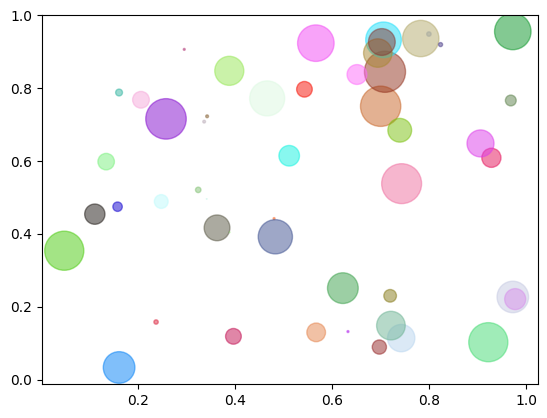

In [3]:
# exemple pour la génération de points colorés

import matplotlib.pyplot as plt
import numpy as np
N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N,3)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

In [2]:
###  TODO )"," TODO ",\
    txt, flags=re.DOTALL))
f2.close()

### </CORRECTION> ###